# Multi-class Classification and Neural Networks

Stanford CS229 - Machine Learning by Andrew Ng. Programming exercise 3 with solutions.

Please check out [the repository on GitHub](https://github.com/rickwierenga/CS229-Python/). If you spot any mistakes or inconcistencies, please create an issue. For questions you can find me on Twitter: [@rickwierenga](https://twitter.com/rickwierenga). Starring the project on GitHub means a ton to me!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import minimize
%matplotlib inline

## Multi-class Classification

---
For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.

In [2]:
# start by loading the data
import scipy.io as sio

data = sio.loadmat("ex3data1.mat")
X = data["X"]
y = data["y"]
y = y.reshape(len(y))

m, n = X.shape

### Visualising the data
Draw 100 random samples from the dataset.

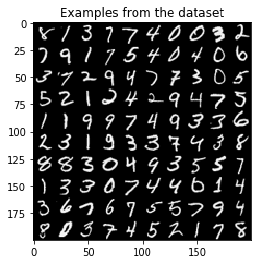

In [3]:
import random
from PIL import Image

# get 100 random images from the dataset
num_samples = 100
samples = random.sample(list(X), num_samples)
display_img = Image.new('RGB', (200, 200))

# loop over the images, turn them into a PIL image
i = 0
for col in range(10):
    for row in range(10):
        array = samples[i]
        array = ((array / max(array)) * 255).reshape((20, 20)).transpose() # redistribute values
        img = Image.fromarray(array)
        display_img.paste(img, (col*20, row*20))
        i += 1

# present display_img
plt.title('Examples from the dataset')
plt.imshow(display_img, interpolation='nearest')

In [4]:
# Add a bias column to X
bias = np.ones((m,1))
X = np.append(bias, X, axis=1)

### Compute the Cost and Gradient
The following functions are copied from [ex2](https://github.com/rickwierenga/CS229-Python/tree/master/ex2).

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
def compute_regularized_cost(theta, X, y, _lambda):
    m = len(y)
    regularization = _lambda / (2 * m) * np.sum(theta[1:] ** 2) #np.squared()???/
    cost = 1/m * (-y @ np.log(sigmoid(X @ theta)) - (1 - y) @ np.log(1 - sigmoid(X@theta)))
    return cost + regularization

In [7]:
def compute_regularized_gradient(theta, X, y, _lambda):
    m = len(y)
    n = len(theta)
    gradient = np.ones(n)
    hx = sigmoid(X @ theta)
    gradient = (1 / m) * X.T @ (hx - y)
    regularization = (_lambda / m) * theta
    regularization[0] = 0
        
    return gradient + regularization

### One-vs-all classification
One-vs-all classification works by finding a decision boundary between every class (denoted $k$) and every example that is not in the class (0). We will store the found values for theta as rows in our matrix $\Theta$ (capital) where every column is are the values of $\theta$ like we had in binary classification.

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the K classes in our dataset (numbers 0 through 9). In the handwritten digits dataset, $K = 10$, but your code should work for any value of $K$.

**Exercise**: Implement one-vs-all logistic regression. Your code should return all the classifier parameters in a matrix $\Theta \in \mathbb{R}^{K\times(N+1)}$, where each row of Θ corresponds to the learned logistic regression parameters for one class. `scipy.optimize.minimize` is already imported as `optimize`.

In [62]:
def train(X, y, K, _lambda):
    n = X.shape[1]
    theta = np.zeros((K, n))
    
    for k in range(0, K):
        print("Training {}/{}".format(k+1, K))
        initial_theta = np.zeros(n)
        labels = np.where(y == k+1, 1, 0)
        results = minimize(compute_regularized_cost, initial_theta, args = (X, labels, _lambda),
                  method = 'CG', jac = compute_regularized_gradient, 
                  options = {"maxiter": 400, "disp" : 0})
        found_theta = results.x
        theta[k, :] = found_theta
    
    return theta

In [63]:
K = 10
_lambda = 0.1
theta = train(X, y, K, _lambda)

Training 1/10
Training 2/10
Training 3/10
Training 4/10
Training 5/10
Training 6/10
Training 7/10
Training 8/10
Training 9/10
Training 10/10


### Evaluation
According to the exercise, we should have a 96,46% accuracy over the entire training set using multi-class classification.

In [64]:
# Make sure to add 1 to the result as `y` is one indexed while the prediction is 0 indexed.
accuracy = np.mean(np.argmax(sigmoid(X @ theta.T), axis = 1) + 1 == y) * 100
'Training set accuracy using multi-class classification: {:2}%'.format(accuracy)

'Training set accuracy using multi-class classification: 96.46000000000001%'

## Multi-class Classification with Neural Networks

---
Neural networks are a more advanced model for doing logistic regression. Neural networks are based on the brain. Neurons in the brain are nodes in the network. $x_1, x_2, ... x_n$ are the _input layers_ of the network and the hypothesis $h_\theta(x)$ is the _output layer_. The output layer exists of $\theta_0, \theta_1, ... \theta_n$.

Between the input layer and output layer are _hidden layer(s)_. Each connection in the network has a weight we previously called "theta parameters". The hidden layers' values are denoted by $a$. $a^j$ is the activation of layer $j$ in the network and $a_i^{(j)}$ is the activation (value) for neuron $i$ in layer $j$. Although networks in theory can have an infinte number of neurons, it is often impraticial to use too many layers at it slows down learning and training dramatically. You should choose the number of hidden layers depending on the complexity of your dataset.

Each neuron has an _activation function_. In this case we use the sigmoid function.

For a network consisting of a single layer with 3 neurons in the input and hidden layer with one neuron in the output layer, the proces would like something like: (note that $a_0$ os not shown - it will always be equal to a vector of 1's) 

$$\begin{bmatrix}x_0\\x_1\\x_2\end{bmatrix} \rightarrow \begin{bmatrix}a_0^{(2)} \\a_1^{(2)} \\a_2^{(2)} \end{bmatrix} \rightarrow h_\theta(x)$$

With a network wired as shown below and the sigmoid function, $g$, as the activation function, we would optain the values for node $a_i^j$ as follows:

$$a_i^{(j)} = g(\Theta_{i,0}^{(i-j)}x_0 + \Theta_{i,1}^{(i-j)}x_1 + ... + \Theta_{i,n}^{(i-j)}x_n)$$

We can vectorize that as:

$$a_i^{(j)} = g(\theta^{(j-1)}x^{(j-1)})$$

Our neural network is shown in the image below. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1)

<div>
    <img style='max-width:40%;' src='notes/model.png'>
</div>

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses. For this week, you will be using parameters from a neural network that we have already trained. Your goal is to implement the feedforward propagation algorithm to use our weights for prediction. In next week’s exercise, you will write the backpropagation algorithm for learning the neural network parameters.

In [11]:
# load the pretrained weights
theta = sio.loadmat("ex3weights.mat")
theta_1 = theta['Theta1']
theta_2 = theta['Theta2']
theta_1.shape, theta_2.shape

((25, 401), (10, 26))

### Feedforward propogation

Feedforward propogation is the routing of the data throught the neueral network to get a prediction. In multi-class classificiation, the output layer of the network exists of multiple neurons. The output of the network, therefore, is a vector consisisting of probalities for each class. Remember the formula for forwarding data described above.

**Exercise**: Implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example i and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $(h_\theta(x))_k$.

In [12]:
def add_bias(X):
    bias = np.ones((m,1))
    X = np.append(bias, X, axis=1)
    return X

In [13]:
def forward(theta, X):
    return sigmoid(theta @ X.T).T

In [14]:
layer2_activation = add_bias(forward(theta_1, X))
predictions = forward(theta_2, layer2_activation)

### Evaluation
According to the exercise, we should have a 97,52% accuracy over the entire training set using neural networks.

In [15]:
# Make sure to add 1 to the result as `y` is one indexed while `predictions` is 0 indexed.
accuracy = np.mean(np.argmax(sigmoid(predictions), axis = 1) + 1 == y) * 100
'Training set accuracy using neural networks: {:2}%'.format(accuracy)

'Training set accuracy using neural networks: 97.52%'

Let's make a couple of predictions using the neural network. Most predictions should be correct.

In [58]:
i = random.randint(0, m)
prediction = np.argmax(sigmoid(predictions[i])) + 1
answer = y[i]

'The neural network predicts {} and the correct answer is {}. This means that it got the answer {}.' \
.format(prediction, answer, 'right' if prediction == answer else 'wrong')

'The neural network predicts 3 and the correct answer is 3. This means that it got the answer right.'